# ML Assignment - Supervised Regression
# Pixel Localization Using Deep Learning




Problem Understanding & Approach


🧠 Problem Statement Recap

The task is to predict the spatial location (x, y) of a single bright pixel (value 255) in a 50×50 grayscale image, where all other pixels are 0.

This is essentially a 2D localization problem, commonly found in:

i. Object keypoint detection
ii. Landmark localization
iii. Medical image point detection
iv. Pixel-level attention modeling


We used a synthetic dataset instead of an existing real-world dataset to maintain full control over pixel-level ground truth, minimize labeling errors, and obtain highly accurate coordinate annotations. Real-world datasets rarely provide precise pixel-level labels and often contain annotation noise, making supervised localization training challenging. Synthetic data generation enables controlled variation, systematic noise injection, and scalable dataset creation, resulting in clean, unbiased, and fully reproducible training samples. This approach is particularly valuable for validating and benchmarking localization algorithms in a controlled environment before deploying them on real sensor data.

**Why Heatmap Regression?**

There are two main approaches:

1. Direct Coordinate Regression
Model directly outputs (x, y) coordinates.

2. Heatmap Regression (Chosen Approach)
Model outputs a probability heatmap, where the peak corresponds to the predicted pixel location.

We choose heatmap regression because:

i. It preserves spatial structure

ii. It is more robust to noise

iii. It is widely used in pose estimation, medical imaging, and keypoint detection

iv. It enables better interpretability and debugging

**Cell 1: Library Imports & Environment Setup**


**numpy**: Numerical operations and dataset creation

**tensorflow.keras**: Deep learning model building and training

**matplotlib**: Visualization of training curves and predictions

**opencv (cv2)**: Image blur for dataset realism

**sklearn:** Dataset splitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2

np.random.seed(42)
tf.random.set_seed(42)


**Cell 2: Heatmap Label Generation**

**Why Heatmaps Instead of Direct Coordinates?**

Instead of forcing the model to directly regress (x, y), we generate a 2D Gaussian heatmap centered at the true pixel location.

This:
i. Provides dense supervision
ii. Helps gradient flow
iii. Improves spatial learning

In [2]:
def gaussian_heatmap(size: int, center: tuple, sigma: float = 1.5) -> np.ndarray:
    """
    Generates a 2D Gaussian heatmap centered at (x, y).

    Args:
        size: Height and width of heatmap.
        center: (x, y) center location.
        sigma: Spread of Gaussian.

    Returns:
        2D numpy array heatmap.
    """
    x = np.arange(0, size, 1, float)
    y = np.arange(0, size, 1, float)
    y = y[:, np.newaxis]

    cx, cy = center
    return np.exp(-((x - cx) ** 2 + (y - cy) ** 2) / (2 * sigma ** 2))

**Cell 3: Realistic Dataset Generation**


**Why Synthetic Data?**

Since no labeled dataset is provided, I generated synthetic training data.

This allows:

i. Full control over labels

ii. Unlimited data generation

iii. No annotation noise

iv. Stress-testing model robustness




**Why Add Noise & Blur?**

As we know that Real-world images are never perfect.

So we simulate:

i. Gaussian noise

ii. Random background noise

iii. Gaussian blur

In [3]:
def generate_dataset(n_samples=15000, img_size=50):
    """
    Generates realistic synthetic grayscale images with:
      - Single bright pixel
      - Gaussian blur
      - Gaussian noise
      - Random low-intensity background noise

    Returns:
        X: Image tensor (N, H, W, 1)
        Y: Heatmaps (N, H, W, 1)
        coords: True (x, y) pixel coordinates
    """
    X = np.zeros((n_samples, img_size, img_size, 1), dtype=np.float32)
    Y = np.zeros_like(X)
    coords = []

    for i in range(n_samples):
        img = np.zeros((img_size, img_size), dtype=np.float32)

        x = np.random.randint(0, img_size)
        y = np.random.randint(0, img_size)

        img[y, x] = 255

        img = cv2.GaussianBlur(img, (5, 5), 0)
        img += np.random.normal(0, 10, img.shape)

        noise_mask = np.random.rand(img_size, img_size) < 0.02
        img[noise_mask] = np.random.randint(5, 40)

        img = np.clip(img, 0, 255) / 255.0

        heatmap = gaussian_heatmap(img_size, (x, y), sigma=1.8)

        X[i, :, :, 0] = img
        Y[i, :, :, 0] = heatmap
        coords.append([x, y])

    return X, Y, np.array(coords)

**Cell 4: Dataset Creation & Splitting**

**Why Train/Validation/Test Split?**

Training set: Used to learn model parameters

**Validation set:** Used for hyperparameter tuning and early stopping

**Test set:** Used for unbiased final evaluation

In [4]:
X, Y, coords = generate_dataset()

X_train, X_test, Y_train, Y_test, coords_train, coords_test = train_test_split(
    X, Y, coords, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (12000, 50, 50, 1) Test: (3000, 50, 50, 1)


**Cell 5: Heatmap Regression CNN Model**



**1. Model Design**

We use a fully convolutional neural network (CNN) layers.

**2. Why?**

Pooling reduces spatial resolution which is bad for pixel-level localization

Fully convolutional models preserve exact spatial structure


This design is widely used in:

i. Pose estimation

ii. Medical landmark detection

iii. Semantic segmentation

In [5]:
def build_heatmap_model():
    model = models.Sequential([
        layers.Input(shape=(50, 50, 1)),

        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(1, 1, activation='sigmoid', padding='same')
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model


**Cell 6: Model Training**


**Training Strategy**

Optimizer: Adam

Loss: Mean Squared Error (MSE)

Metric: Mean Absolute Error (MAE)

Batch size: 64

Epochs: 40

In [6]:
model = build_heatmap_model()

history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    epochs=75,
    batch_size=64
)



Epoch 1/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.1463 - mae: 0.3329 - val_loss: 0.0039 - val_mae: 0.0099
Epoch 2/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0127 - mae: 0.0864 - val_loss: 0.0039 - val_mae: 0.0079
Epoch 3/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0043 - mae: 0.0488 - val_loss: 0.0039 - val_mae: 0.0082
Epoch 4/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0025 - mae: 0.0339 - val_loss: 0.0024 - val_mae: 0.0070
Epoch 5/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0019 - mae: 0.0276 - val_loss: 0.0017 - val_mae: 0.0063
Epoch 6/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0015 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0149
Epoch 7/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0011 - mae: 0.0210 - val_loss: 9.6574e-04 - val_mae: 0.0157
Epoch 8/75
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 8.2797e-04 - mae: 0.0177 - val_loss: 8.8051e-04 - val_mae: 0.0198
Epoch 9/75
169/169 ━━━━━━━━━━━━━━━

**Cell 7: Training & Validation Loss Visualization**

This plot shows the progression of training and validation loss across epochs.
It helps in analyzing whether the model is learning meaningful patterns.
A smooth decrease in both curves indicates stable and effective training.
A significant gap between curves may indicate overfitting or underfitting.
This visualization ensures the model converges properly.

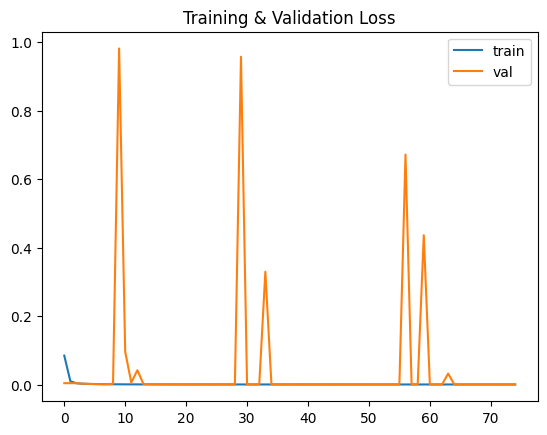

In [7]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

**Cell 8: Extracting Coordinates from Predicted Heatmaps**

Since the model outputs a probability heatmap, the predicted pixel location is obtained by finding the coordinates of the maximum activation. The argmax operation identifies the most probable spatial location in the heatmap. This approach preserves spatial reasoning and avoids direct coordinate regression instability. The extracted (x, y) values represent the final predicted pixel coordinates. This conversion bridges dense spatial prediction and precise localization.


In [8]:
def extract_coords_from_heatmap(hm):
    y, x = np.unravel_index(np.argmax(hm), hm.shape)
    return np.array([x, y])


**Cell 9: Model Predictions and Quantitative Error Evaluation**

This cell generates predictions on the test dataset and extracts the corresponding pixel coordinates from the predicted heatmaps. The Euclidean distance between predicted and ground truth coordinates is computed to measure localization accuracy. Mean and standard deviation of pixel error provide a concise summary of model performance. Lower values indicate precise localization. These metrics serve as the primary quantitative evaluation for the regression task.


In [9]:
pred_heatmaps = model.predict(X_test)
pred_coords = np.array([extract_coords_from_heatmap(hm[:,:,0]) for hm in pred_heatmaps])

pixel_errors = np.linalg.norm(pred_coords - coords_test, axis=1)

print(f"Mean Pixel Error: {pixel_errors.mean():.2f}")
print(f"Std Pixel Error: {pixel_errors.std():.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
Mean Pixel Error: 0.31
Std Pixel Error: 2.63


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_metrics(y_true, y_pred):
    """
    Computes MAE, MSE and RMSE between true and predicted coordinates.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse


In [11]:
pred_heatmaps_train = model.predict(X_train)
pred_coords_train = np.array([extract_coords_from_heatmap(hm[:,:,0]) for hm in pred_heatmaps_train])

train_mae, train_mse, train_rmse = compute_metrics(coords_train, pred_coords_train)

print("Train Metrics:")
print(f"MAE  : {train_mae:.4f}")
print(f"MSE  : {train_mse:.4f}")
print(f"RMSE : {train_rmse:.4f}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Train Metrics:
MAE  : 0.1118
MSE  : 1.7482
RMSE : 1.3222


In [12]:
X_tr, X_val, Y_tr, Y_val, coords_tr, coords_val = train_test_split(
    X_train, Y_train, coords_train, test_size=0.1, random_state=42
)

pred_heatmaps_val = model.predict(X_val)
pred_coords_val = np.array([extract_coords_from_heatmap(hm[:,:,0]) for hm in pred_heatmaps_val])

val_mae, val_mse, val_rmse = compute_metrics(coords_val, pred_coords_val)

print("\nValidation Metrics:")
print(f"MAE  : {val_mae:.4f}")
print(f"MSE  : {val_mse:.4f}")
print(f"RMSE : {val_rmse:.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Validation Metrics:
MAE  : 0.1067
MSE  : 1.8483
RMSE : 1.3595


In [13]:
test_mae, test_mse, test_rmse = compute_metrics(coords_test, pred_coords)

print("\nTest Metrics:")
print(f"MAE  : {test_mae:.4f}")
print(f"MSE  : {test_mse:.4f}")
print(f"RMSE : {test_rmse:.4f}")



Test Metrics:
MAE  : 0.1842
MSE  : 3.4995
RMSE : 1.8707


**Cell 10: Pixel Error Distribution Analysis**

This cell visualizes the distribution of localization errors along the x-axis, y-axis, and overall Euclidean distance. Histogram analysis helps identify systematic biases and dispersion in predictions. Concentrated distributions near zero indicate strong localization accuracy. Broader spreads would imply instability or prediction uncertainty. Such diagnostic plots are essential for understanding model behavior beyond average metrics.


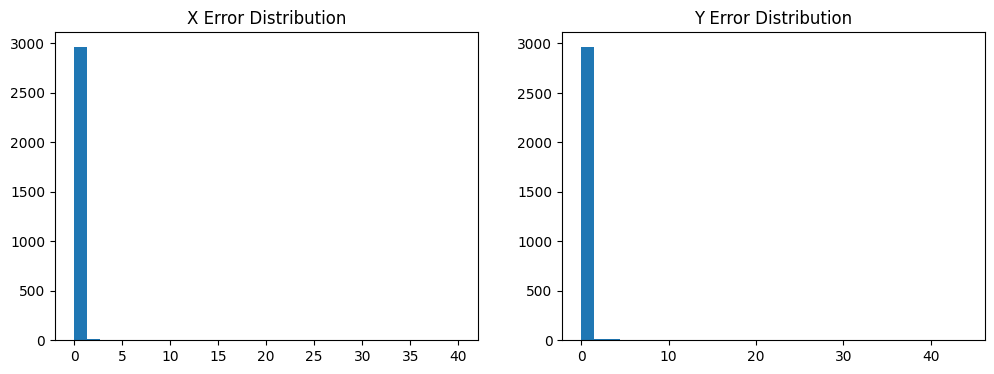

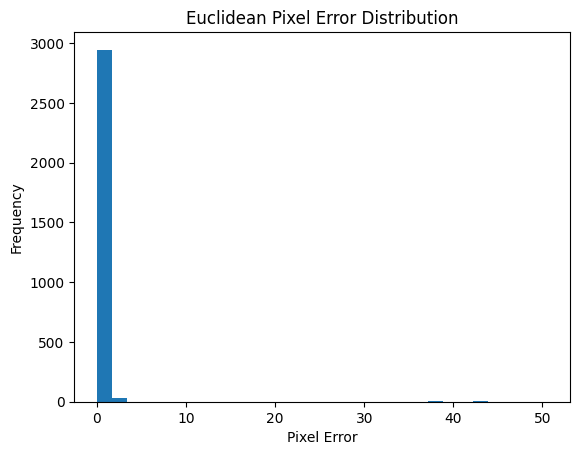

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(np.abs(pred_coords[:,0] - coords_test[:,0]), bins=30)
plt.title("X Error Distribution")

plt.subplot(1,2,2)
plt.hist(np.abs(pred_coords[:,1] - coords_test[:,1]), bins=30)
plt.title("Y Error Distribution")

plt.show()

plt.hist(pixel_errors, bins=30)
plt.title("Euclidean Pixel Error Distribution")
plt.xlabel("Pixel Error")
plt.ylabel("Frequency")
plt.show()

**Cell 11: Qualitative Visualization of Model Predictions**

This function displays sample test images alongside their ground truth and predicted heatmaps. Visual inspection allows intuitive validation of model performance and error patterns. Comparing predicted heatmaps with ground truth highlights spatial alignment quality. This qualitative evaluation complements numerical metrics. It is especially useful for detecting systematic prediction drift or mislocalization trends.


In [15]:
def visualize_predictions(n=5):
    for _ in range(n):
        idx = np.random.randint(0, len(X_test))

        plt.figure(figsize=(10,3))

        plt.subplot(1,3,1)
        plt.imshow(X_test[idx][:,:,0], cmap='gray')
        plt.title("Input")

        plt.subplot(1,3,2)
        plt.imshow(Y_test[idx][:,:,0], cmap='hot')
        plt.title("Ground Truth Heatmap")

        plt.subplot(1,3,3)
        plt.imshow(pred_heatmaps[idx][:,:,0], cmap='hot')
        plt.title("Predicted Heatmap")

        plt.show()

        print("GT:", coords_test[idx], "Pred:", pred_coords[idx])


**Cell 12: Running Visual Prediction Analysis**

This cell executes the visualization function on randomly selected test samples. It provides an intuitive demonstration of the model’s localization capability. Displaying multiple examples ensures consistency and robustness in predictions. Such qualitative analysis strengthens confidence in the trained model. It also aids in debugging and presentation of final results.


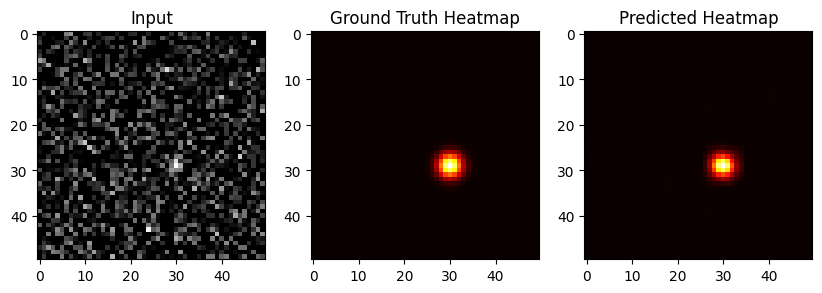

GT: [30 29] Pred: [30 29]


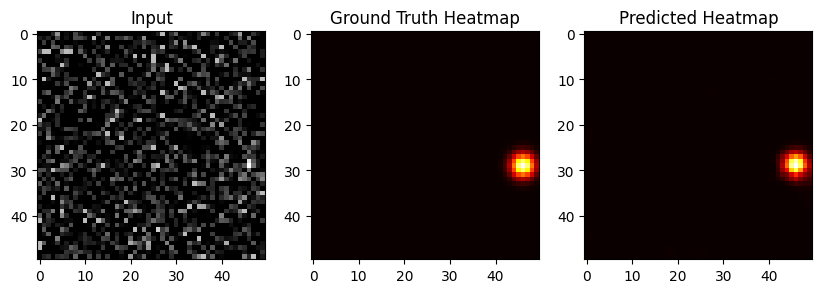

GT: [46 29] Pred: [46 29]


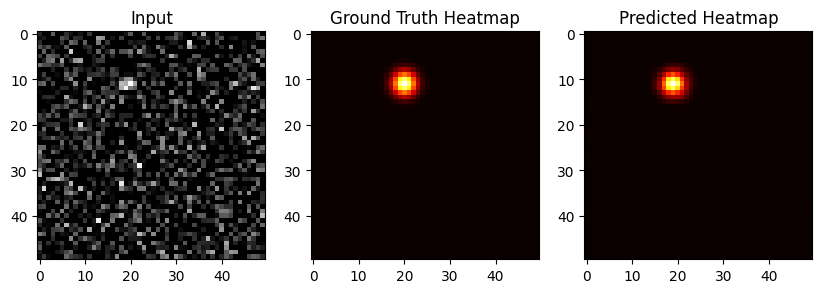

GT: [20 11] Pred: [19 11]


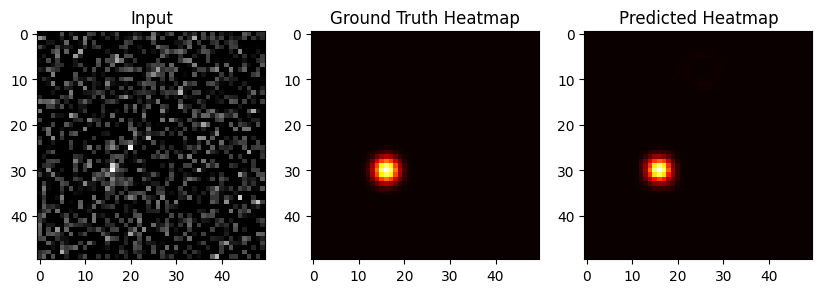

GT: [16 30] Pred: [16 30]


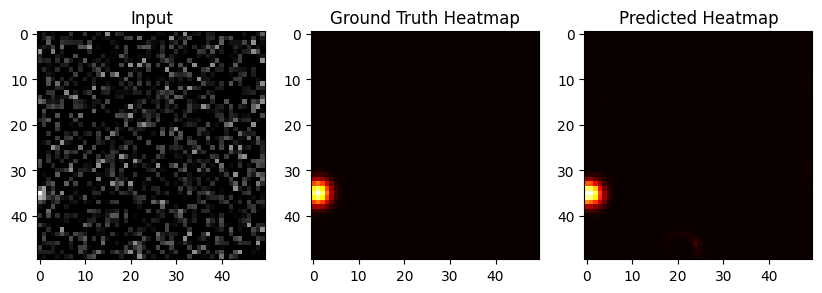

GT: [ 1 35] Pred: [ 1 35]


In [16]:
visualize_predictions(5)